<img width = 85% src='rapids_motivation.png'>

<img width = 75% src='choices.png'>

# Table of Contents

1. [ Generate a classification dataset on GPU ](#data-gen) (e.g., double helix, unwinding helix/whirl )

2. [ ETL - process/prepare data for model training ](#ETL) (e.g., scale, split, augment )
   > controllably breaking IID : non-identically distributed train and test data
    
3. [ Single model training ](#single-model)
   > CPUs vs 1 GPU
  - TODO summarize : accuracy (model predictions & errors viz), wall clocks, cleanup
  
4. [ Define HPO Strategy ](#define-hpo)

5. [ Scaling up within a node using Dask ](#scale-up-single-node-hpo)
   > LocalCUDACluster 
      
6. [ Scaling out across nodes with Dask + Kubernetes ](#scale-out-multi-node-hpo)
   > kubernetes (+kubeflow)
   
   > from dask_kubernetes import KubeCluster
   

In [52]:
import numpy as np; import numpy.matlib

In [53]:
import ipyvolume as ipv

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [55]:
# algos, datasets
import xgboost; from xgboost import plot_tree
from sklearn import datasets; from sklearn.metrics import confusion_matrix, accuracy_score

In [56]:
import cupy
import cudf

In [57]:
import time; from time import sleep

In [74]:
import rapids_lib_v11 as rl
''' NOTE: anytime changes are made to rapids_lib.py you can either:
      1. refresh/reload via the code below, OR
      2. restart the kernel '''
import importlib; importlib.reload(rl)

<module 'rapids_lib_v11' from '/rapids-dask-hpo/rapids/HPO/rapids_lib_v11.py'>

<a id = 'data-gen'></a>
# 1. Data Generation
-----


We will generate data shapes [coordinate lists] and hand them to the GPU. The GPU will randomly build 3D blobs [ cupy.random.normal ] around each coordinate point to create a much larger, noisier, and more realistic dataset.

Using this concept we offer the following dataset variations:
1. Helix - two entwined coils, inspired by DNA casing
2. Whirl - an increasingly unwinding Helix 

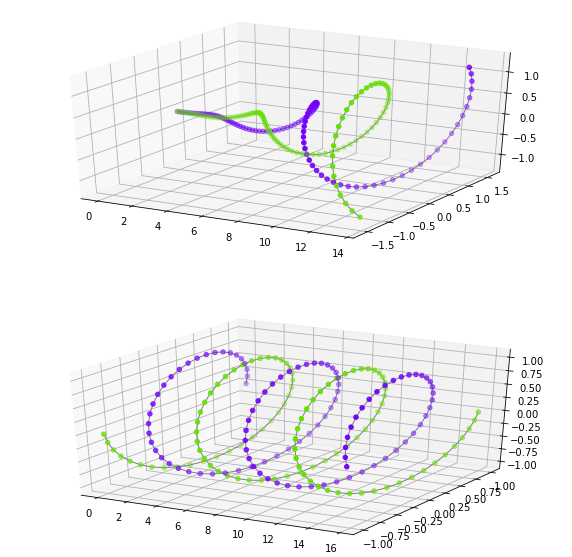

In [59]:
rl.plot_dataset_variants()

# Helix and Whirl Datasets

In [60]:
nBlobPoints = 1000
nCoordinates = 400

sdevScales = [ .3, .3, .3]
noiseScale = 1/10.

coilDensity = 12
trainTestOverlap = .05

In [61]:
data, labels, t_gen = rl.gen_blob_coils( coilType='whirl', shuffleFlag = False, 
                                         nBlobPoints = nBlobPoints,  
                                         nCoordinates = nCoordinates, 
                                         sdevScales = sdevScales, 
                                         noiseScale = noiseScale, 
                                         coilDensity = coilDensity )

generating blobs; # points = 400000
generating blobs; # points = 400000
time to generate data on GPU = 0.3478703498840332
	 plotting data - stride = 8 


In [62]:
data, labels, t_gen = rl.gen_blob_coils( coilType='helix', shuffleFlag = False, 
                                         nBlobPoints = nBlobPoints,  
                                         nCoordinates = nCoordinates, 
                                         sdevScales = sdevScales, 
                                         noiseScale = noiseScale, 
                                         coilDensity = coilDensity )

generating blobs; # points = 400000
generating blobs; # points = 400000
time to generate data on GPU = 0.3454422950744629
	 plotting data - stride = 8 


<a id = 'ETL'></a>
# 2. ETL
-----

In [63]:
expLog = {}

## Standard Scaler [ Normalize ]

In [64]:
def scale_dataframe_inplace ( targetDF, trainMeans = {}, trainSTDevs = {} ):    
    print('rescaling data')
    sT = time.time()
    for iCol in targetDF.columns:
        
        # omit scaling label column
        if iCol == targetDF.columns[-1] == 'label': continue
            
        # compute means and standard deviations for each column [ should skip for test data ]
        if iCol not in trainMeans.keys() and iCol not in trainSTDevs.keys():            
            trainMeans[iCol] = targetDF[iCol].mean()
            trainSTDevs[iCol] = targetDF[iCol].std()
            
        # apply scaling to each column
        targetDF[iCol] = ( targetDF[iCol] - trainMeans[iCol] ) / ( trainSTDevs[iCol] + 1e-10 )
        
    return trainMeans, trainSTDevs, time.time() - sT

### **CPU** split & scale

In [65]:
# split
trainData_pDF, trainLabels_pDF, testData_pDF, testLabels_pDF, t_split_CPU = rl.split_train_test_nfolds ( data.to_pandas(), labels.to_pandas(), trainTestOverlap = trainTestOverlap )

# apply standard scaling
trainMeans_CPU, trainSTDevs_CPU, t_scaleTrain_CPU = scale_dataframe_inplace ( trainData_pDF )
_,_, t_scaleTest_CPU = scale_dataframe_inplace ( testData_pDF, trainMeans_CPU, trainSTDevs_CPU )    

expLog = rl.update_log( expLog, [['CPU_split_train_test', t_split_CPU],
                                 ['CPU_scale_train_data', t_scaleTrain_CPU], 
                                 ['CPU_scale_test_data', t_scaleTest_CPU]] )

splitting data into training and test set
rescaling data
rescaling data
 + adding log entry [ CPU_split_train_test     :   0.06668 s ]
 + adding log entry [ CPU_scale_train_data     :   0.15615 s ]
 + adding log entry [ CPU_scale_test_data      :   0.09628 s ]


### **GPU** split & scale

In [66]:
# split
trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, t_split = rl.split_train_test_nfolds ( data, labels, trainTestOverlap = trainTestOverlap )

# apply standard scaling
trainMeans, trainSTDevs, t_scaleTrain = scale_dataframe_inplace ( trainData_cDF )
_,_, t_scaleTest = scale_dataframe_inplace ( testData_cDF, trainMeans, trainSTDevs )    

expLog = rl.update_log( expLog, [['GPU_split_train_test', t_split],
                                 ['GPU_scale_train_data', t_scaleTrain],
                                 ['GPU_scale_test_data', t_scaleTest]] ); 

splitting data into training and test set
rescaling data
rescaling data
 + adding log entry [ GPU_split_train_test     :   0.11741 s ]
 + adding log entry [ GPU_scale_train_data     :   0.00716 s ]
 + adding log entry [ GPU_scale_test_data      :   0.00466 s ]


# IID Breaking 

train data stride 72, test data stride 8


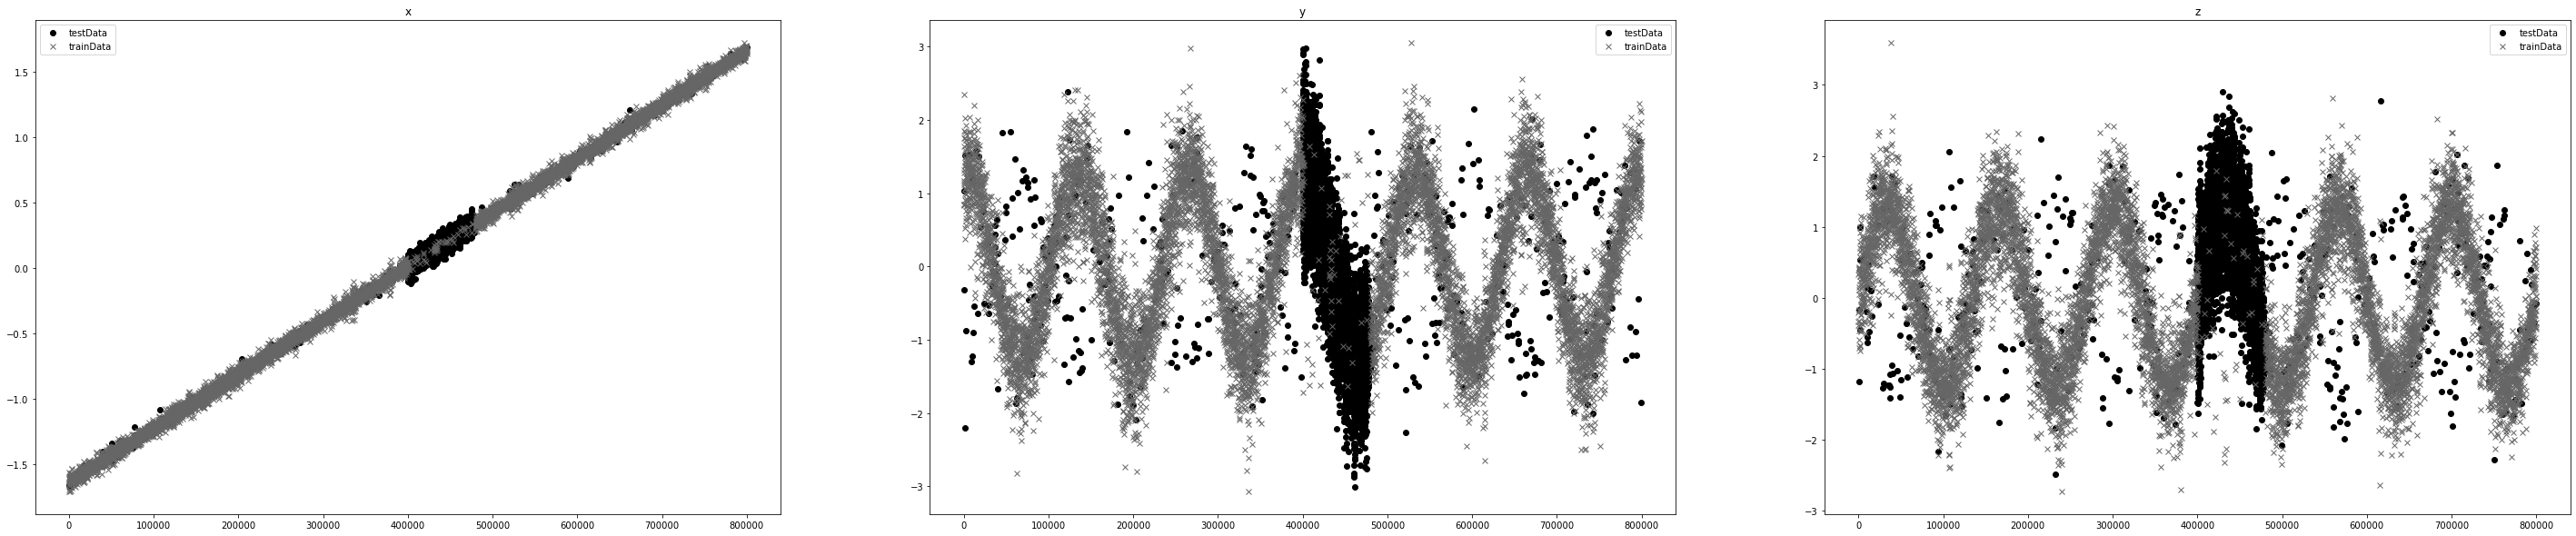

In [67]:
rl.plot_iid_breaking ( trainData_pDF, testData_pDF )

In [75]:
rl.plot_train_test(trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF)

<a id = 'single-model'></a>
# 3. Single Model Training & Eval
-----

In [18]:
''' -------------------------------------------------------------------------
>  GPU Train and Test
------------------------------------------------------------------------- '''
def train_model_GPU (trainData_cDF, testData_cDF, paramsGPU = {}):    
    print('training xgboost model on GPU');  
    startTime = time.time()    
    
    trainDMatrix = xgboost.DMatrix( trainData_cDF.to_pandas(), label = trainLabels_cDF.to_pandas())    
    trainedModelGPU = xgboost.train( dtrain = trainDMatrix, params = paramsGPU, num_boost_round = paramsGPU['num_boost_rounds'] )
    
    return trainedModelGPU, time.time() - startTime

def test_model_GPU ( trainedModelGPU, testData_cDF, testLabels_cDF ):
    print('testing xgboost model on GPU')
    startTime = time.time()   
    
    testDMatrix = xgboost.DMatrix( data = testData_cDF.to_pandas(), label = testLabels_cDF.to_pandas())    
    predictionsGPU = trainedModelGPU.predict(testDMatrix)
    
    return predictionsGPU, time.time() - startTime

''' -------------------------------------------------------------------------
>  CPU Train and Test
------------------------------------------------------------------------- '''
def train_model_CPU (trainData_cDF, trainLabels_cDF, paramsCPU = {}):    
    print('training xgboost model on {} CPU cores'.format(nCores) )

    startTime = time.time()
    
    trainDMatrix = xgboost.DMatrix( trainData_cDF.to_pandas(), label = trainLabels_cDF.to_pandas())
    
    xgBoostModelCPU = xgboost.train( dtrain = trainDMatrix, params = paramsCPU, num_boost_round = paramsCPU['num_boost_rounds'])
    
    return xgBoostModelCPU, time.time() - startTime

def test_model_CPU ( trainedModelCPU, testData_cDF, testLabels_cDF ):
    print('testing xgboost model on CPU')
    startTime = time.time()
    
    testDMatrix = xgboost.DMatrix( testData_cDF.to_pandas(), label = testLabels_cDF.to_pandas())
    predictionsCPU = trainedModelCPU.predict(testDMatrix)
    
    return predictionsCPU, time.time() - startTime

### Define model parameters
https://xgboost.readthedocs.io/en/latest/parameter.html

In [19]:
nCores = !nproc --all
nCores = int(nCores[0])

In [20]:
nCores

40

In [21]:
paramsCPU = {
    'max_depth': 3,
    'num_boost_rounds': 100,    
    'learning_rate': .1,
    'lambda': 1,    
    'objective': 'binary:hinge',
    'tree_method': 'hist',
    'n_jobs': nCores,
    'random_state': 0
}

paramsGPU = {
    'max_depth': 3,
    'num_boost_rounds': 100,
    'learning_rate': .1,
    'lambda': 1,    
    'objective': 'binary:hinge',
    'tree_method': 'gpu_hist',
    'n_gpus': 1,    
    'random_state': 0
}

### **CPU** Training and Inference

In [22]:
trainedModelCPU, t_trainCPU = train_model_CPU ( trainData_cDF, trainLabels_cDF, paramsCPU )

training xgboost model on 40 CPU cores


In [23]:
predictionsCPU, t_inferCPU = test_model_CPU ( trainedModelCPU, testData_cDF, testLabels_cDF)

testing xgboost model on CPU


In [24]:
expLog = rl.update_log( expLog, [['CPU_model_training', t_trainCPU], ['CPU_model_inference', t_inferCPU]] ); 

 + adding log entry [ CPU_model_training       :   4.21798 s ]
 + adding log entry [ CPU_model_inference      :   0.02576 s ]


### **GPU** Model Training and Inference

In [25]:
trainedModelGPU, t_trainGPU = train_model_GPU ( trainData_cDF, trainLabels_cDF, paramsGPU )

training xgboost model on GPU


In [26]:
predictionsGPU, t_inferGPU = test_model_GPU ( trainedModelGPU, testData_cDF, testLabels_cDF)

testing xgboost model on GPU


In [27]:
expLog = rl.update_log( expLog, [['GPU_model_training', t_trainGPU], ['GPU_model_inference', t_inferGPU]] ); 

 + adding log entry [ GPU_model_training       :   0.31487 s ]
 + adding log entry [ GPU_model_inference      :   0.01442 s ]


### Compare CPU and GPU Accuracy [ plot on train and test ]

In [28]:
trainLabels_pDF = trainLabels_cDF.to_pandas()
testLabels_pDF = testLabels_cDF.to_pandas()

trainPredictionsCPU, _ = test_model_CPU ( trainedModelCPU, trainData_cDF, trainLabels_cDF)
trainPredictionsGPU, _ = test_model_GPU ( trainedModelGPU, trainData_cDF, trainLabels_cDF)
trainAccuracyCPU = accuracy_score(trainLabels_pDF, trainPredictionsCPU)
trainAccuracyGPU = accuracy_score(trainLabels_pDF, trainPredictionsGPU)
print( 'train data CPU accuracy = {}'.format( trainAccuracyCPU ) )
print( 'train data GPU accuracy = {}'.format( trainAccuracyGPU ) )

accuracyCPU = accuracy_score(testLabels_pDF, predictionsCPU)
accuracyGPU = accuracy_score(testLabels_pDF, predictionsGPU)
print( 'test data CPU accuracy = {}'.format( accuracyCPU ) )
print( 'test data GPU accuracy = {}'.format( accuracyGPU ) )

testing xgboost model on CPU
testing xgboost model on GPU
train data CPU accuracy = 0.8624583333333333
train data GPU accuracy = 0.8612347222222222
test data CPU accuracy = 0.2555625
test data GPU accuracy = 0.2511875


In [29]:
cMat = confusion_matrix(testLabels_pDF, predictionsGPU)
print(cMat)

[[ 7324 32601]
 [27304 12771]]


### Visualize the first decision tree

CPU times: user 65.3 ms, sys: 24.2 ms, total: 89.5 ms
Wall time: 195 ms


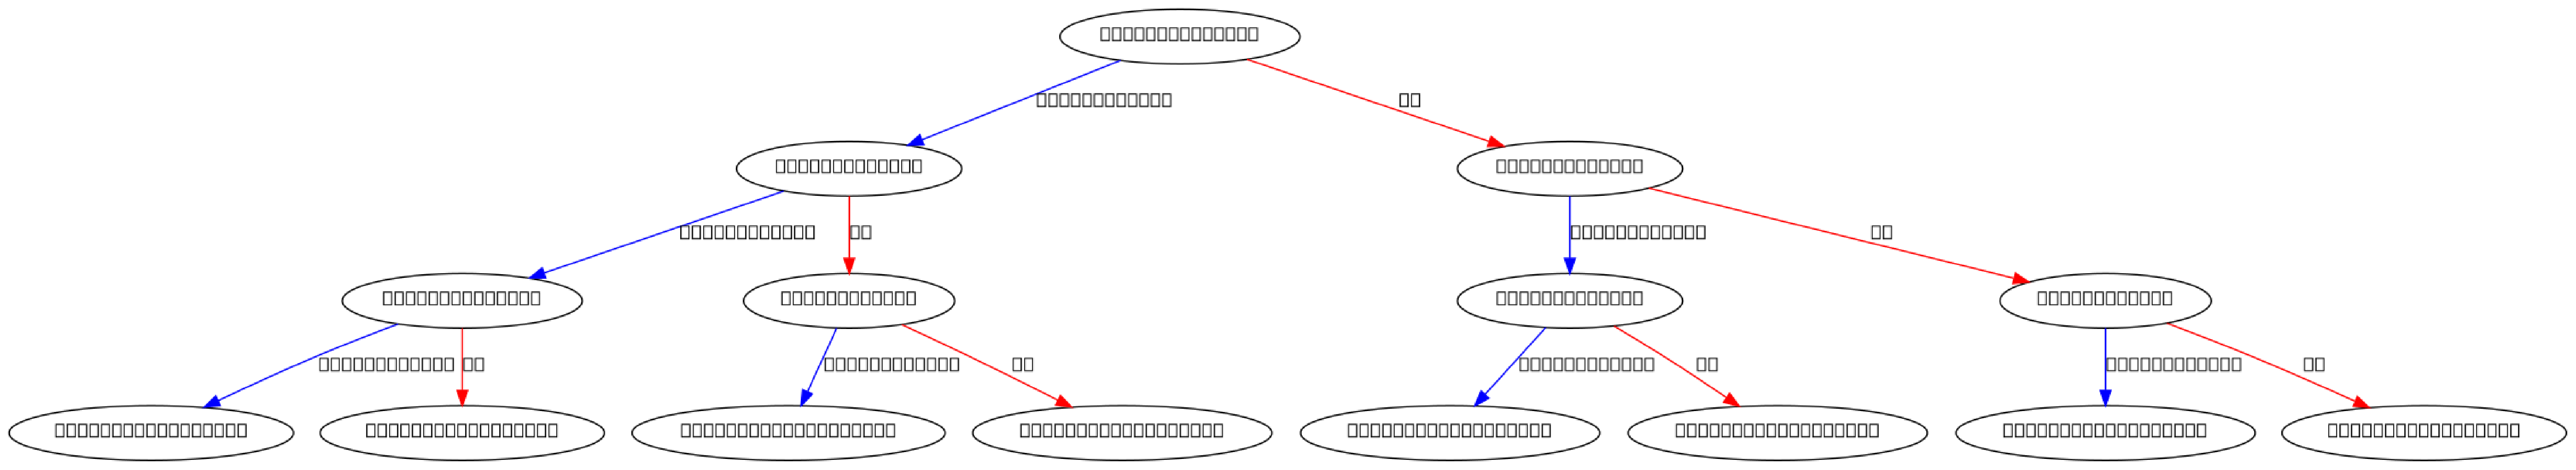

In [30]:
%%time
fig = plt.figure(figsize=(100,50))
plot_tree(trainedModelGPU, num_trees=0, ax=plt.subplot(1,1,1))

In [31]:
expLog

{'CPU_split_train_test': 0.06581926345825195,
 'CPU_scale_train_data': 0.08929896354675293,
 'CPU_scale_test_data': 0.054184913635253906,
 'GPU_split_train_test': 0.2560558319091797,
 'GPU_scale_train_data': 0.007513761520385742,
 'GPU_scale_test_data': 0.004585981369018555,
 'CPU_model_training': 4.217979669570923,
 'CPU_model_inference': 0.025762557983398438,
 'GPU_model_training': 0.3148679733276367,
 'GPU_model_inference': 0.01442408561706543}

<a id = 'define-hpo'></a>
# 4. Define HPO Strategy
-----

## Defining the search range of the target parameters

In [32]:
paramRanges = { 0: ['max_depth', 3, 15, 'int'],
                1: ['learning_rate', .001, 1, 'float'],
                2: ['lambda', 0, 10, 'float'] }

## Defining the settings of the particle swarm 

In [33]:
nTimesteps = 10
nParticles = 32

### Particle Swarm : 
> Random Particle Initialization

> Particle Movement defined by a balance of exploration (i.e., random movement) + exploitation (i.e., swarming to know best location)

In [34]:
def update_particles( paramRanges, particlesInTimestep, velocitiesInTimestep, bestParamsIndex, globalBestParams, sBest = .85, sExplore = .1 , deltaTime = 1, randomSeed = None):
    
    nParticles = particlesInTimestep.shape[ 0 ]
    nParameters = particlesInTimestep.shape[ 1 ]    
        
    globalBestRepeated = numpy.matlib.repmat( np.array( globalBestParams ).reshape( -1, 1 ), nParticles, 1).reshape( nParticles, nParameters )    

    if randomSeed is not None: np.random.seed(randomSeed)
        
    # move to best + explore | globalBest + personalBest
    velocitiesInTimestep += sBest * ( globalBestRepeated - particlesInTimestep ) + sExplore * ( np.random.randn( nParticles, nParameters ) )
    
    particlesInTimestep += velocitiesInTimestep * deltaTime 
    
    # enforce param bounds
    for iParam in range( nParameters ):
        particlesInTimestep[ :, iParam ] = np.clip(particlesInTimestep[ :, iParam ], paramRanges[iParam][1], paramRanges[iParam][2])
        if paramRanges[iParam][3] == 'int':
            particlesInTimestep[ :, iParam ] = np.round( particlesInTimestep[ :, iParam ] )
            
    return particlesInTimestep, velocitiesInTimestep
    

### Particle Training using Changing Parameter Sets

In [35]:
def train_model_hpo ( trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, particleParams, iParticle, iTimestep ):
    
    # fixed parameters
    paramsGPU = { 'objective': 'binary:hinge',
                  'tree_method': 'gpu_hist',
                  'n_gpus': 1,
                  'random_state': 0 }
    
    # parameters to search over
    paramsGPU['max_depth'] = int(particleParams[0])
    paramsGPU['learning_rate'] = particleParams[1]
    paramsGPU['lambda'] = particleParams[2]
    paramsGPU['num_boost_rounds'] = 1000
    
    startTime = time.time()
    trainDMatrix = xgboost.DMatrix( data = trainData_cDF, label = trainLabels_cDF )
    testDMatrix = xgboost.DMatrix( data = testData_cDF, label = testLabels_cDF )
    trainedModelGPU = xgboost.train( dtrain = trainDMatrix, evals = [(testDMatrix, 'test')], 
                                     params = paramsGPU,
                                     num_boost_round = paramsGPU['num_boost_rounds'],
                                     early_stopping_rounds = 15,
                                     verbose_eval = False )
    
    elapsedTime = time.time() - startTime
    
    return trainedModelGPU, elapsedTime

### Particle Evaluation Logic

In [36]:
def test_model_hpo ( trainedModelGPU, trainingTime, testData_cDF, testLabels_cDF ):
    
    startTime = time.time()
    
    testDMatrix = xgboost.DMatrix( data = testData_cDF, label = testLabels_cDF )    
    predictionsGPU = trainedModelGPU.predict( testDMatrix ).astype(int)
    
    return predictionsGPU, trainedModelGPU.best_iteration, trainingTime, time.time() - startTime

<a id = 'scale-up-single-node-hpo'></a>
# 5. Scaling up within a node using Dask
-----

In [37]:
import dask
from dask import delayed
from dask_cuda import LocalCUDACluster
from dask_kubernetes import KubeCluster
from dask.distributed import Client

In [38]:
cluster = LocalCUDACluster(ip='', n_workers = 4)

In [39]:
client = Client(cluster)

### Pre-scatter Demo

We'll demonstrate how we can scatter data across all workers with a small subset of the train and test data.
Pre-scattering the dataset ensures that no additional I/O is needed during the HPO search (other than the particles sharing their performance).

In [40]:
if client is not None:        
    samplesToScatterTrain = int( trainData_cDF.shape[0] * .01 )
    samplesToScatterTest = int( testData_cDF.shape[0] * .01 )
    scatteredData_future = client.scatter( [ trainData_cDF[0:samplesToScatterTrain], 
                                             testData_cDF[0:samplesToScatterTest] ], 
                                             broadcast = True)    

In [41]:
scatteredData_future

[<Future: status: finished, type: DataFrame, key: DataFrame-6029e4f5c8eea1acc41cef4d2b61a808>,
 <Future: status: finished, type: DataFrame, key: DataFrame-9abe8dc4eeaaa3f9c4ffeeef2ebdf1fd>]

In [42]:
print ( '{} \n {} \n'.format( scatteredData_future[0].key, scatteredData_future[1].key ) )
client.who_has(scatteredData_future)

DataFrame-6029e4f5c8eea1acc41cef4d2b61a808 
 DataFrame-9abe8dc4eeaaa3f9c4ffeeef2ebdf1fd 



{'DataFrame-9abe8dc4eeaaa3f9c4ffeeef2ebdf1fd': ('tcp://172.17.0.2:39431',
  'tcp://172.17.0.2:46107',
  'tcp://172.17.0.2:38165',
  'tcp://172.17.0.2:44213'),
 'DataFrame-6029e4f5c8eea1acc41cef4d2b61a808': ('tcp://172.17.0.2:39431',
  'tcp://172.17.0.2:38165',
  'tcp://172.17.0.2:44213',
  'tcp://172.17.0.2:46107')}

In [43]:
del( scatteredData_future )

### Run HPO

In [44]:
accuracies, particles, velocities, particleSizes, particleColors, bestParticleIndex, \
bestParamIndex, particleBoostingRounds, trainingTimes, predictionHistory, elapsedTime = rl.run_hpo ( client, nTimesteps, 
                                                                                                  nParticles,
                                                                                                  paramRanges, 
                                                                                                  trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF )

@ hpo timestep : 0, best accuracy is 0.9512125
	 updating best GLOBAL accuracy
@ hpo timestep : 1, best accuracy is 0.9527
	 updating best GLOBAL accuracy
@ hpo timestep : 2, best accuracy is 0.9515125
@ hpo timestep : 3, best accuracy is 0.9505625
@ hpo timestep : 4, best accuracy is 0.9514
@ hpo timestep : 5, best accuracy is 0.951525
@ hpo timestep : 6, best accuracy is 0.952725
	 updating best GLOBAL accuracy
@ hpo timestep : 7, best accuracy is 0.9510125
@ hpo timestep : 8, best accuracy is 0.9502375
@ hpo timestep : 9, best accuracy is 0.9502375
highest accuracy               :  0.952725 
   @ timestep 6, particle 17 

best model tree depth          :  5.0 
best model learning rate       :  0.8335521669442962 
best model regularization      :  0.11902468106903752 
best model num boosting rounds :  49 
elapsed time : 60.628666162490845


### Visualize particle search trajectories

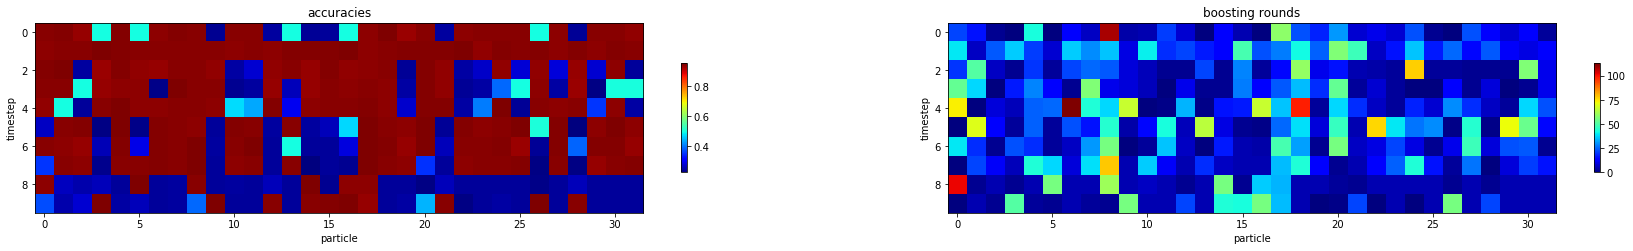

In [45]:
rl.viz_search( accuracies, particleBoostingRounds )

In [46]:
rl.hpo_animate (particles, particleSizes, particleColors, paramRanges, nTimesteps = nTimesteps )

### Visualize the Prediction Trajectory of the Top Particle [ ending at its best timestep ]

In [47]:
rl.plot_particle_learning ( nTimesteps, nParticles, testData_pDF, bestParamIndex, predictionHistory )

### Clean up and close LocalCUDACluster based client before launching dask-kubernetes

In [48]:
client.close(); sleep(10)

<a id='scale-out-multi-node-hpo'></a>
    
# 6. Scaling out accross nodes with Dask + Kubernetes
    
-------
 

Configure the dask workers within Kubernetes by defining the target container and resource settings.

In [49]:
worker_spec_fname = '/worker_spec.yaml'
worker_spec = '''
# worker-spec.yml

kind: Pod
metadata:
  labels:
    foo: bar
spec:
  restartPolicy: Never
  containers:
  - image: ericharper/rapids-dask-hpo:latest
    imagePullPolicy: IfNotPresent
    args: [dask-worker,  --nthreads, '1', --no-bokeh, --memory-limit, 0, --death-timeout, '60']
    name: dask
    resources:
      limits:
        cpu: "2"
        memory: 6G
        nvidia.com/gpu: 1
      requests:
        cpu: "2"
        memory: 6G
        nvidia.com/gpu: 1
'''

with open(worker_spec_fname, "w") as yaml_file:
    yaml_file.write(worker_spec)

### Initialize Dask

In [50]:
kube_ip = !echo $KUBEFLOW_CONTROLLER_SERVICE_HOST

In [51]:
assert kube_ip[0], ('No kubernetes controller found! Unable to proceed')

AssertionError: No kubernetes controller found! Unable to proceed

### Set number of workers [ changes require kernel restart ]

In [ ]:
cluster = KubeCluster.from_yaml( worker_spec_fname )

In [ ]:
client = Client(cluster)

In [ ]:
client

In [ ]:
cluster

## Simple Run

Now that we have a cluster, lets test the performance with just a few workers.

In [ ]:
nWorkers = 4

In [ ]:
# scale down cluster
cluster.scale ( nWorkers ); sleep(10)

# trigger HPO computations
rl.run_hpo ( client, nTimesteps, nParticles, paramRanges, trainData_cDF,
          trainLabels_cDF, testData_cDF, testLabels_cDF, plotFlag = False )

# scale down cluster
cluster.scale ( 0 ); sleep(10)

## Adaptive Run

In [ ]:
minWorkers = 1
maxWorkers = 4

In [ ]:
# scale down cluster
cluster.scale( 0 ); sleep(10) 

# enable adaptive scaling
cluster.adapt( minimum = minWorkers, maximum = maxWorkers ) 

# trigger HPO computations
rl.run_hpo ( client, nTimesteps, nParticles, paramRanges, trainData_cDF,
          trainLabels_cDF, testData_cDF, testLabels_cDF, plotFlag = False )

# scale down cluster
cluster.scale( 0 ); sleep(10)

## Benchmark scaling across entire cluster

Now that we have a cluster, we can scale the computation accross available workers. 
Below we perform a set of experiments using different subsets of the cluster and measure scaling performance.

In [ ]:
runScalingTest = False

# define set of experiments for scaling [ list of nWorkers per experiment ]
scalingExperimentSet = [ 8, 4, 1]

if runScalingTest:    
    if dask_type == "k8s":
        for iWorkers in scalingExperimentSet:
        cluster.scale( iWorkers ); sleep(10)
        rl.run_hpo ( client, nTimesteps, nParticles, paramRanges, trainData_cDF,
                  trainLabels_cDF, testData_cDF, testLabels_cDF, plotFlag = False )
        cluster.scale( 0 ); sleep(10)

### Clean Up Cluster

In [ ]:
client.close()

## Appendix
----
##### Jupyter Extensions
* [Dask Extension](https://github.com/dask/dask-labextension)
* [NVIDIA System Dashboard](https://github.com/jacobtomlinson/jupyterlab-nvdashboard/blob/master/README.md)

##### Dask Kubernetes
* [Example Notebook](https://github.com/supertetelman/k8s-rapids-dask/blob/master/k8s_examples/Scaling%20Dask%20in%20Kubernetes.ipynb)
* [Docker Image](https://github.com/supertetelman/k8s-rapids-dask/blob/master/Dockerfile)
* [K8S/Kubeflow/Dask Deployment Guide](https://github.com/NVIDIA/deepops/blob/master/docs/kubernetes-cluster.md)
* [Official Docs](https://kubernetes.dask.org/en/latest/)